In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
%matplotlib inline
import pandas_profiling
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns

We've talked about Random Forests. Now it's time to build one.

Here we'll use data from Lending Club to predict the state of a loan given some information about it. You can find the dataset [here](https://www.lendingclub.com/info/download-data.action). We'll use 2015 data. ([Thinkful mirror](https://www.dropbox.com/s/m7z42lubaiory33/LoanStats3d.csv?dl=0))

In [2]:
# Replace the path with the correct path for your data.
y2015 = pd.read_csv(
    'https://www.dropbox.com/s/0so14yudedjmm5m/LoanStats3d.csv?dl=1',
    skipinitialspace=True,low_memory=False,
    header=1
)

# Note the warning about dtypes.

In [3]:

y2015.info() 
# identify objects



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421097 entries, 0 to 421096
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(85), object(26)
memory usage: 356.6+ MB


In [4]:
desc = y2015.describe(include='all').T
# print (desc)

the dataset has so many columns that I need some routine to analyze 
1. what columns have
   - more than %XX NULLS
   - the same values for XX % 
   - variance < than X % of column value 
   - columns that use huge space
 ---------------------------
 describe; info ? 


In [ ]:
# get all base info for all columns
profile = pandas_profiling.ProfileReport(y2015)

In [11]:
profile.to_file(outputfile="y2015_profile.html")

In [5]:
X = y2015.drop('loan_status', 1)
Y = y2015['loan_status']


## Data Cleaning

Well, `get_dummies` can be a very memory intensive thing, particularly if data are typed poorly. We got a warning about that earlier. Mixed data types get converted to objects, and that could create huge problems. Our dataset is about 400,000 rows. If there's a bad type there its going to see 400,000 distinct values and try to create dummies for all of them. That's bad. Lets look at all our categorical variables and see how many distinct counts there are...

In [6]:
categorical = y2015.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    print(column.nunique())

id
421097
term
2
int_rate
110
grade
7
sub_grade
35
emp_title
120812
emp_length
11
home_ownership
4
verification_status
3
issue_d
12
loan_status
7
pymnt_plan
1
url
421095
desc
34
purpose
14
title
27
zip_code
914
addr_state
49
earliest_cr_line
668
revol_util
1211
initial_list_status
2
last_pymnt_d
25
next_pymnt_d
4
last_credit_pull_d
26
application_type
2
verification_status_joint
3


Well that right there is what's called a problem. Some of these have over a hundred thousand distinct types. Lets drop the ones with over 30 unique values, converting to numeric where it makes sense. In doing this there's a lot of code that gets written to just see if the numeric conversion makes sense. It's a manual process that we'll abstract away and just include the conversion.

You could extract numeric features from the dates, but here we'll just drop them. There's a lot of data, it shouldn't be a huge problem.

In [7]:
# Convert ID and Interest Rate to numeric.
y2015['id'] = pd.to_numeric(y2015['id'], errors='coerce')
y2015['int_rate'] = pd.to_numeric(y2015['int_rate'].str.strip('%'), errors='coerce')

# Drop other columns with many unique variables
y2015.drop(['url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
            'sub_grade', 'addr_state', 'desc'], 1, inplace=True)

Wonder what was causing the dtype error on the id column, which _should_ have all been integers? Let's look at the end of the file.

In [8]:
y2015.tail()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
421092,36271333.0,38982739.0,13000.0,13000.0,13000.0,60 months,15.99,316.07,D,5 years,...,0.0,3.0,100.0,50.0,1.0,0.0,51239.0,34178.0,10600.0,33239.0
421093,36490806.0,39222577.0,12000.0,12000.0,12000.0,60 months,19.99,317.86,E,1 year,...,1.0,2.0,95.0,66.7,0.0,0.0,96919.0,58418.0,9700.0,69919.0
421094,36271262.0,38982659.0,20000.0,20000.0,20000.0,36 months,11.99,664.20,B,10+ years,...,0.0,1.0,100.0,50.0,0.0,1.0,43740.0,33307.0,41700.0,0.0
421095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Remove two summary rows at the end that don't actually contain data.
y2015 = y2015[:-2]

Now this should be better. Let's try again.



## The first full attempt

Now let's try this model again.

We're also going to drop NA columns, rather than impute, because our data is rich enough that we can probably get away with it.

This model may take a few minutes to run.

In [10]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
X = y2015.drop('loan_status', 1)
Y = y2015['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

cross_val_score(rfc, X, Y, cv=10)

C:\Users\Vadim\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vadim\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vadim\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vadim\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vadim\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

array([ 0.98057515,  0.98029019,  0.98154876,  0.98178623,  0.97430539,
        0.9773688 ,  0.95364411,  0.9808117 ,  0.97976583,  0.97876787])

In [11]:
# let's first repeat it by my understanding 


The score cross validation reports is the accuracy of the tree. Here we're about 98% accurate.

That works pretty well, but there are a few potential problems. Firstly, we didn't really do much in the way of feature selection or model refinement. As such there are a lot of features in there that we don't really need. Some of them are actually quite impressively useless.

There's also some variance in the scores. The fact that one gave us only 93% accuracy while others gave higher than 98 is concerning. This variance could be corrected by increasing the number of estimators. That will make it take even longer to run, however, and it is already quite slow.

## DRILL: Second Attempt

So here's your task. Get rid of as much data as possible without dropping below an average of 90% accuracy in a 10-fold cross validation.

You'll want to do a few things in this process. First, dive into the data that we have and see which features are most important. This can be the raw features or the generated dummies. You may want to use PCA or correlation matrices.

Can you do it without using anything related to payment amount or outstanding principal? How do you know?

In [12]:
# Your code here.
# Task Get rid of as much data as possible without dropping below an average of 90% accuracy in a 10-fold cross validation.
# First, dive into the data that we have and see which features are most important. 
# 
# You don't have to use pcs use just need to fill nulls. in some cases it is better to fill then to drop. 
#
print ('Loan Status counts')
Y.value_counts()

Loan Status counts


Current               287414
Fully Paid             87989
Charged Off            29178
Late (31-120 days)      9510
In Grace Period         4320
Late (16-30 days)       1888
Default                  796
Name: loan_status, dtype: int64

In [13]:
# can't plot it. !!!
# Y.hist(bins=100)
#plt.show()

In [14]:
print(list(X))
      

['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_cre

In [15]:
zz=X.drop([ 'member_id',  'funded_amnt', 'funded_amnt_inv', 'delinq_2yrs', 'inq_last_6mths', 'pub_rec',  'total_acc',  'out_prncp_inv',  'total_pymnt_inv'\
      ,  'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med',   'tot_cur_bal'\
      , 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal',  'delinq_amnt', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl'\
      , 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats',  'num_il_tl', 'num_op_rev_tl', 'num_rev_tl_bal_gt_0',  'num_tl_30dpd'\
      , 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',  'pub_rec_bankruptcies',    'term_ 36 months', 'term_ 60 months', 'grade_A', 'grade_B', 'grade_C'\
      , 'grade_D', 'grade_E', 'grade_F',  'emp_length_10+ years', 'emp_length_2 years', 'emp_length_3 years', 'emp_length_4 years', 'emp_length_5 years'\
      , 'emp_length_6 years', 'emp_length_7 years', 'emp_length_8 years', 'emp_length_9 years', 'emp_length_< 1 year',  'home_ownership_MORTGAGE'\
      , 'home_ownership_OWN', 'verification_status_Not Verified', 'verification_status_Source Verified', 'verification_status_Verified', 'issue_d_Apr-2015'\
      , 'issue_d_Aug-2015', 'issue_d_Dec-2015', 'issue_d_Feb-2015', 'issue_d_Jan-2015', 'issue_d_Jul-2015', 'issue_d_Jun-2015', 'issue_d_Mar-2015'\
      , 'issue_d_May-2015', 'issue_d_Nov-2015', 'issue_d_Oct-2015', 'issue_d_Sep-2015',  'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation'\
      , 'purpose_educational', 'purpose_home_improvement', 'purpose_major_purchase', 'purpose_medical', 'purpose_moving', 'purpose_other'\
      , 'purpose_renewable_energy', 'purpose_small_business', 'purpose_vacation', 'purpose_wedding', 'title_Business', 'title_Car financing'\
      , 'title_Credit Card/Auto Repair', 'title_Credit card refinancing', 'title_Debt consolidation', 'title_DebtC', 'title_Green loan'\
      , 'title_Home buying', 'title_Home improvement', 'title_Learning and training', 'title_Major purchase', 'title_Medical expenses'\
      , 'title_Moving and relocation', 'title_New Baby and New House (CC Consolidate)', 'title_Other', 'title_Pay off Lowes Card'\
      , 'title_Paying off higher interest cards & auto', 'title_Prescription Drug and Medical Costs', 'title_SAVE','total_rec_prncp'\
      , 'title_Simple Loan Until Contract Is Completed', 'title_Student Loan', 'title_Trying to come back to reality!'\
      , 'title_Vacation', 'title_considerate', 'title_new day', 'title_new kitchen for momma!', 'title_odymeds', 'initial_list_status_f'\
      , 'initial_list_status_w', 'last_pymnt_d_Apr-2015', 'last_pymnt_d_Apr-2016', 'last_pymnt_d_Aug-2015', 'last_pymnt_d_Aug-2016'\
      , 'last_pymnt_d_Dec-2015', 'last_pymnt_d_Dec-2016', 'last_pymnt_d_Feb-2015', 'last_pymnt_d_Feb-2016', 'last_pymnt_d_Jan-2015'\
      , 'last_pymnt_d_Jan-2016', 'last_pymnt_d_Jan-2017', 'last_pymnt_d_Jul-2015', 'last_pymnt_d_Jul-2016', 'last_pymnt_d_Jun-2015'\
      , 'last_pymnt_d_Jun-2016', 'last_pymnt_d_Mar-2015', 'last_pymnt_d_Mar-2016', 'last_pymnt_d_May-2015', 'last_pymnt_d_May-2016'\
      , 'last_pymnt_d_Nov-2015', 'last_pymnt_d_Nov-2016', 'last_pymnt_d_Oct-2015', 'last_pymnt_d_Oct-2016', 'last_pymnt_d_Sep-2015'\
      , 'last_pymnt_d_Sep-2016', 'next_pymnt_d_Feb-2017', 'next_pymnt_d_Jan-2017', 'next_pymnt_d_Jul-2016', 'next_pymnt_d_Mar-2017'\
      , 'last_credit_pull_d_Apr-2015', 'last_credit_pull_d_Apr-2016', 'last_credit_pull_d_Aug-2015', 'last_credit_pull_d_Aug-2016'\
      , 'last_credit_pull_d_Dec-2014', 'last_credit_pull_d_Dec-2015', 'last_credit_pull_d_Dec-2016', 'last_credit_pull_d_Feb-2015'\
      , 'last_credit_pull_d_Feb-2016', 'last_credit_pull_d_Jan-2015', 'last_credit_pull_d_Jan-2016', 'last_credit_pull_d_Jan-2017'\
      , 'last_credit_pull_d_Jul-2015', 'last_credit_pull_d_Jul-2016', 'last_credit_pull_d_Jun-2015', 'last_credit_pull_d_Jun-2016'\
      , 'last_credit_pull_d_Mar-2015', 'last_credit_pull_d_Mar-2016', 'last_credit_pull_d_May-2015', 'last_credit_pull_d_May-2016'\
      , 'last_credit_pull_d_Nov-2015', 'last_credit_pull_d_Nov-2016', 'last_credit_pull_d_Oct-2015', 'last_credit_pull_d_Oct-2016'\
      , 'last_credit_pull_d_Sep-2015', 'last_credit_pull_d_Sep-2016', 'application_type_INDIVIDUAL', 'application_type_JOINT'
], axis=1)

In [16]:
zz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421095 entries, 0 to 421094
Data columns (total 32 columns):
id                                           421095 non-null float64
loan_amnt                                    421095 non-null float64
int_rate                                     421095 non-null float64
installment                                  421095 non-null float64
annual_inc                                   421095 non-null float64
dti                                          421095 non-null float64
open_acc                                     421095 non-null float64
revol_bal                                    421095 non-null float64
out_prncp                                    421095 non-null float64
total_pymnt                                  421095 non-null float64
policy_code                                  421095 non-null float64
acc_now_delinq                               421095 non-null float64
tot_coll_amt                                 421095 non-null 

In [17]:
z = pd.get_dummies(zz)
z = z.dropna(axis=1)


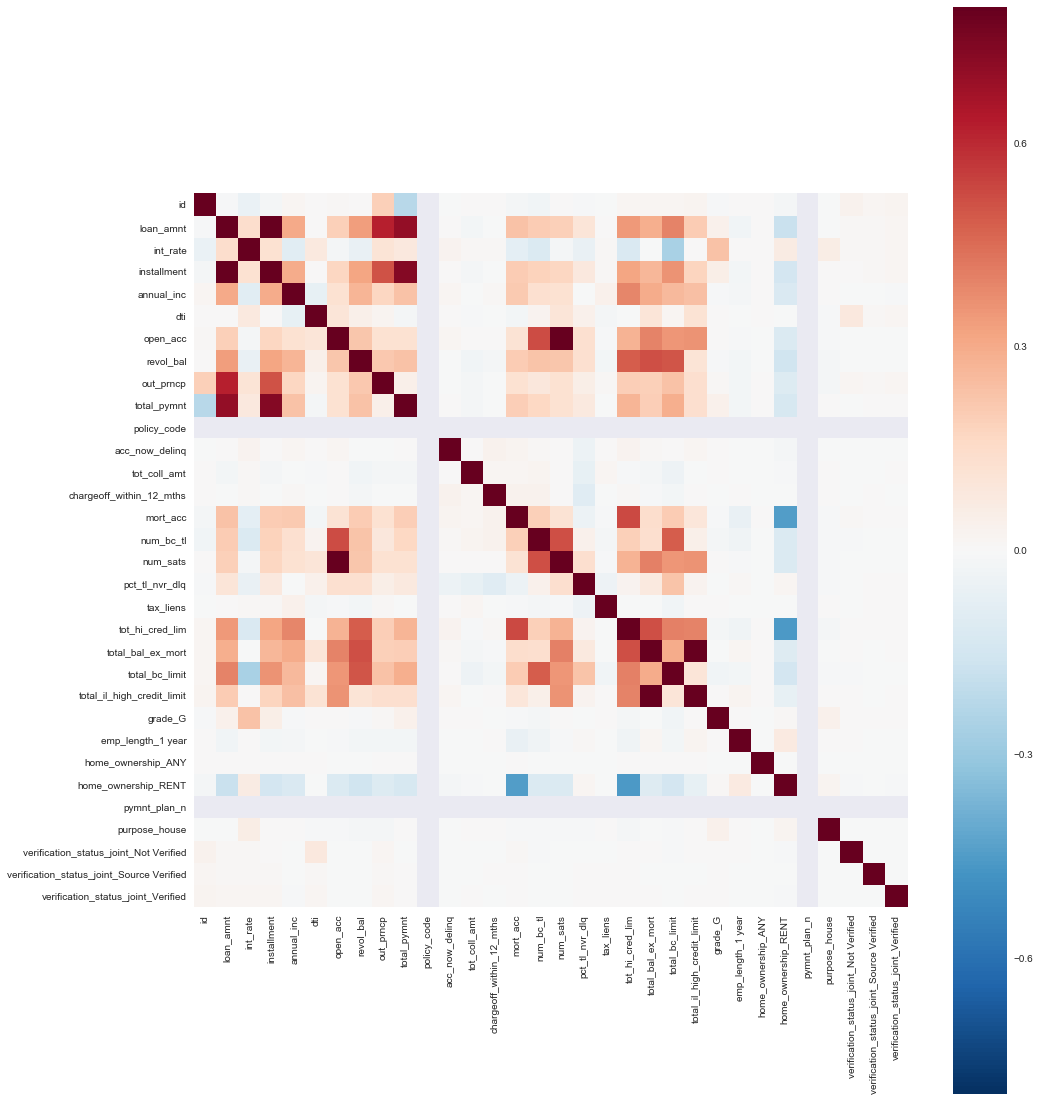

In [18]:
corrmat = z.corr()
plt.figure(figsize=(16, 20))
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()



In [19]:
#  loan status already dropped from the data
Y = y2015['loan_status']
X1 = pd.get_dummies(zz)
X1 = X1.dropna(axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X1, Y, test_size=0.2, random_state=10)
print( 'y ' + str(Y.shape) + 'X1' + str(X1.shape))

y (421095,)X1(421095, 32)


In [20]:
rfc = ensemble.RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_valid)
#f1_score = f1_score(y_pred, y_valid, average='micro')

C:\Users\Vadim\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [21]:
print( 'preict ' + str(y_pred.shape) + 'y_valid' + str(y_valid.shape))
#f1_score = f1_score(y_pred, y_valid)
#print(f1_score) 

preict (84219,)y_valid(84219,)


In [22]:
f1_score = f1_score(y_pred, y_valid, average='micro')

In [23]:
print("f1 score " + str(f1_score))

f1 score 0.959094741092


In [27]:
print(list(zz))

['id', 'loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc', 'revol_bal', 'out_prncp', 'total_pymnt', 'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'chargeoff_within_12_mths', 'mort_acc', 'num_bc_tl', 'num_sats', 'pct_tl_nvr_dlq', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'grade_G', 'emp_length_1 year', 'home_ownership_ANY', 'home_ownership_RENT', 'pymnt_plan_n', 'purpose_house', 'verification_status_joint_Not Verified', 'verification_status_joint_Source Verified', 'verification_status_joint_Verified']


In [31]:
zz= zz.drop([ 'policy_code', 'home_ownership_RENT', 'pymnt_plan_n'   ],axis=1)

In [33]:
Y = y2015['loan_status']
X1 = pd.get_dummies(zz)
X1 = X1.dropna(axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X1, Y, test_size=0.2, random_state=10)
print( 'y ' + str(Y.shape) + 'X1' + str(X1.shape))
rfc = ensemble.RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_valid)
f1_score = f1_score(y_pred, y_valid, average='micro')
print("f1 score " + str(f1_score))

y (421095,)X1(421095, 25)


C:\Users\Vadim\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TypeError: 'numpy.float64' object is not callable